# 2.4. Nächste-Nachbarn-Klassifikation

>## <ins>Table of contents</ins>
>* [**2.4.1. k-nearest neighbour (KNN) Grundlagen**](#2_4_1)
>* [**2.4.2.  Nächste-Nachbarn-Regression**](#2_4_2)
>* [**2.4.3. Merkmalskalierung**](#2_4_3)
>* [**2.4.4. Nicht-lineare Modelle**](#nl_modelle)

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt


## 2.6.1. Das Modell der Entscheidungsbäume <a name="2_6_1"></a>

**Entscheidungsbaum**
- Ein Entscheidungsbaum ist ein gerichteter Baum.
- Jeder Knoten stellt eine Fallunterscheidung für den Wert eines Merkmals eines gegebenen Datenpunktes dar.
- Für jeden Fall gibt es einen eindeutigen Nachfolgerknoten.
- Die Blätter des Baumes enthalten die möglichen Klassifikationen des betrachteten Datenpunkts.
- Ein Pfad von der Wurzel des Entscheidungsbaums zu einem Blatt stellt eine Reihe von Entscheidungen bzgl. eines Datenpunktes dar, die zu einer Klassifikation führen.

**Definition eines Entscheidungsbaums**
- Sei $X = X_1 × ... × X_n$ der Merkmalsraum von $n$ Merkmalen und $Y$ die Menge der Klassen (oder der Zielraum bei Regressionsproblemen).
- Ein Entscheidungsbaum $T$ für $X$ und $Y$ ist ein Tupel $T = (V,E,r)$ mit:
    1. $(V,E)$ ist ein (abwärts) gerichteter Baum mit Wurzel r.
    2. Ein Blattknoten $v ∈ V$ heißt auch Klassifikationsknoten mit $cl(v) ∈ Y$.
    3. Ein innerer Knoten $v ∈ V$ heißt auch Entscheidungsknoten mit (sei ${v_1,..., v_k}$ die Menge der Nachfolger von v in T):
        - $att(v) ∈ {1,...,n}$ ist das Entscheidungsmerkmal von v und
        - $succ(v)$ ist eine Entscheidungsfunktion $succ(v) : X_{att(v)} → {v_1,..., v_k}$.

**Klassifikation eines Datenpunkts**
- Ist $x = (x1,..., xn)^T ∈ X_1 × ... × X_n$ ein Datenpunkt, so ist die Klassifikation von x bzgl. eines Entscheidungsbaums $T = (V,E,r)$ definiert via : 
$$clf_T(x, v) = \begin{cases}
   cl(v) &\text{falls } v \text{ ein Klassifikationsknoten ist} \\
   clf_T\left(x, succ(v)(x_{att(v)})\right) &\text{sonst }
\end{cases}
$$

**Entscheidungsfunktion**
- Die Entscheidungsfunktion $succ(v)$ (für engl. successor) eines Entscheidungsknotens $v$ wird üblicherweise als einfacher Vergleich mit einer Konstanten realisiert (wie "$x_i < 10$") und $v$ besitzt dann zwei Nachfolger: einen falls der Vergleich positiv ausfällt und einen falls der Vergleich negativ ausfällt.
- Für Merkmale mit endlich vielen Ausprägungen erhält $v$ einen Nachfolger für jede dieser Ausprägungen. 


In [21]:
D_apartment = pd.DataFrame({
    'size': [40, 30, 45, 35, 20, 50, 30, 45, 40, 25],
    'dist': [4, 3, 8, 6, 4, 7, 4, 4, 5, 1],
    'ok': [1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
})
D_apartment

,size,dist,ok
0,40,4,1
1,30,3,1
2,45,8,0
3,35,6,0
4,20,4,0
5,50,7,1
6,30,4,0
7,45,4,1
8,40,5,0
9,25,1,1


Genauigkeit: 1.0


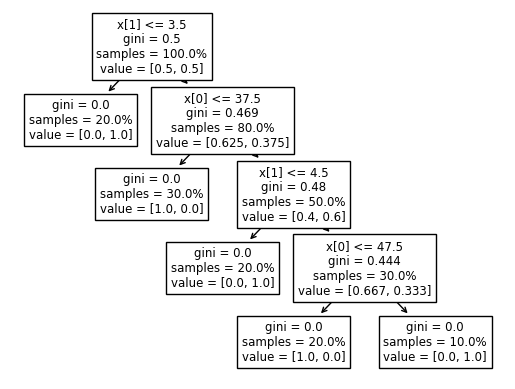

In [18]:
from sklearn.datasets import make_classification
import sklearn.metrics as metrics
from sklearn import tree

# Convert DataFrame to numpy arrays for processing
X = D_apartment.iloc[:, :-1].values
y = D_apartment.iloc[:, -1].values

clf = tree.DecisionTreeClassifier().fit(X, y)

tree.plot_tree(clf,proportion=True)
print("Genauigkeit: "+ str(metrics.accuracy_score(y,clf.predict(X))))

![image.png](./Uebung_2_6/Entscheidungsbaum_D_apartments.PNG)

Wir erhalten ein Entscheidungsbaums `clf` namens $T_{apartment} = (V_{apartment}, E_{apartment}, v_1)$ mit:

- $V_apartment = {v_1,..., v_9}$: Dies definiert die Menge der Knoten im Baum. Es gibt insgesamt 9 Knoten, die als `v1` bis `v9` bezeichnet werden.
- $E_apartment = {(v_1, v_2),(v_1, v_3),(v_3, v_4),(v_3, v_5),(v_5, v_6),(v_5, v_7),(v_7, v_8),(v_7, v_9)}$: Dies definiert die Kanten des Baums, d.h., die Verbindungen zwischen den Knoten. Jedes Paar $(v_i, v_j)$ repräsentiert eine Kante vom Knoten $v_i$ zum Knoten $v_j$.
- $cl(v_i) = x$: Dies definiert die Klassifikation (Ausgabe) des Knotens $v_i$. Wenn ein Datenpunkt zu diesem Knoten gelangt, wird er als Klasse $x$ klassifiziert.
$$cl(v2) = 1$$
$$cl(v4) = 0$$
$$cl(v6) = 1$$
$$cl(v8) = 0$$
$$cl(v9) = 1$$
- $att(v_i) = x$: Dies definiert das Attribut, nach dem am Knoten $v_i$ geteilt wird. In Ihrem Beispiel sind die Attribute numerisch, daher repräsentiert $x$ den Index des Attributs in den Datenpunkten.
$$att(v1) = 2$$
$$att(v3) = 1$$
$$att(v5) = 2$$
$$att(v7) = 1$$

- $succ(v_i)(z)$: Dies definiert die Nachfolgerfunktion am Knoten $v_i$. Sie bestimmt, zu welchem Nachfolgerknoten wir gehen, basierend auf dem Wert $z$ des Attributs am Knoten `vi`. In Ihrem Beispiel ist die Nachfolgerfunktion eine einfache Bedingung auf $z$.
$$succ(v1)(z) = 
    \begin{cases} 
    v2 &\text{falls } z < 4 \\
    v3 &\text{sonst}
    \end{cases}$$

$$succ(v3)(z) = 
    \begin{cases} 
    v4 &\text{falls } z < 37 \\
    v5 &\text{sonst}
    \end{cases}$$
$$succ(v5)(z) = 
    \begin{cases} 
    v6 &\text{falls } z < 5 \\
    v7 &\text{sonst}
    \end{cases}$$
$$succ(v7)(z) = 
    \begin{cases} 
    v8 &\text{falls } z < 47 \\
    v9 &\text{sonst}
    \end{cases}$$


Dieser Entscheidungsbaum in der Lage ist, jeden Datenpunkt im Datensatz `D_apartment` korrekt zu klassifizieren.

clf ein angepasster Entscheidungsbaum. Wir können damit die Klasse neuer Instanzen vorhersagen:

In [33]:
# Assume clf is your fitted DecisionTreeClassifier
instances = [[40, 4], [30, 3]]  # Replace with your instances
predictions = clf.predict(instances)
print(predictions)

ValueError: X has 2 features, but DecisionTreeClassifier is expecting 4 features as input.

#### Beispiel 1:
Wir klassifizieren Filme in die beiden Klassen *Kinderfilm* `0` und *Actionfilm* `1` anhand der beiden Merkmale *Länge* und *Kosten*.

In [23]:
import pandas as pd

D_tennis = pd.read_csv("./uebung_2_6/dataset_tennis.csv")
D_tennis

,outlook,temperature,humidity,wind,tennis
0,sunny,hot,high,weak,no
1,sunny,hot,high,strong,no
2,overcast,hot,high,weak,yes
3,rain,mild,high,weak,yes
4,rain,cool,normal,weak,yes
5,rain,cool,normal,strong,no
6,overcast,cool,normal,strong,yes
7,sunny,mild,high,weak,no
8,sunny,cool,normal,weak,yes
9,rain,mild,normal,weak,yes


In [26]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
D_tennis = D_tennis.apply(le.fit_transform)
D_tennis

,outlook,temperature,humidity,wind,tennis
0,2,1,0,1,0
1,2,1,0,0,0
2,0,1,0,1,1
3,1,2,0,1,1
4,1,0,1,1,1
5,1,0,1,0,0
6,0,0,1,0,1
7,2,2,0,1,0
8,2,0,1,1,1
9,1,2,1,1,1


In [27]:
X = D_tennis.iloc[:, 0:-1].values
y = D_tennis.iloc[:, 4].values

clf = tree.DecisionTreeClassifier().fit(X, y)

In [28]:
from sklearn import preprocessing

X_enc = preprocessing.OrdinalEncoder().fit_transform(X)
X_enc

array([[2., 1., 0., 1.],
       [2., 1., 0., 0.],
       [0., 1., 0., 1.],
       [1., 2., 0., 1.],
       [1., 0., 1., 1.],
       [1., 0., 1., 0.],
       [0., 0., 1., 0.],
       [2., 2., 0., 1.],
       [2., 0., 1., 1.],
       [1., 2., 1., 1.],
       [2., 2., 1., 0.],
       [0., 2., 0., 0.],
       [0., 1., 1., 1.],
       [1., 2., 0., 0.]])

[Text(0.4444444444444444, 0.9, 'x[0] <= 0.5\ngini = 0.459\nsamples = 100.0%\nvalue = [0.357, 0.643]'),
 Text(0.3333333333333333, 0.7, 'gini = 0.0\nsamples = 28.6%\nvalue = [0.0, 1.0]'),
 Text(0.5555555555555556, 0.7, 'x[2] <= 0.5\ngini = 0.5\nsamples = 71.4%\nvalue = [0.5, 0.5]'),
 Text(0.3333333333333333, 0.5, 'x[0] <= 1.5\ngini = 0.32\nsamples = 35.7%\nvalue = [0.8, 0.2]'),
 Text(0.2222222222222222, 0.3, 'x[3] <= 0.5\ngini = 0.5\nsamples = 14.3%\nvalue = [0.5, 0.5]'),
 Text(0.1111111111111111, 0.1, 'gini = 0.0\nsamples = 7.1%\nvalue = [1.0, 0.0]'),
 Text(0.3333333333333333, 0.1, 'gini = 0.0\nsamples = 7.1%\nvalue = [0.0, 1.0]'),
 Text(0.4444444444444444, 0.3, 'gini = 0.0\nsamples = 21.4%\nvalue = [1.0, 0.0]'),
 Text(0.7777777777777778, 0.5, 'x[3] <= 0.5\ngini = 0.32\nsamples = 35.7%\nvalue = [0.2, 0.8]'),
 Text(0.6666666666666666, 0.3, 'x[1] <= 1.0\ngini = 0.5\nsamples = 14.3%\nvalue = [0.5, 0.5]'),
 Text(0.5555555555555556, 0.1, 'gini = 0.0\nsamples = 7.1%\nvalue = [1.0, 0.0]'),
 Te

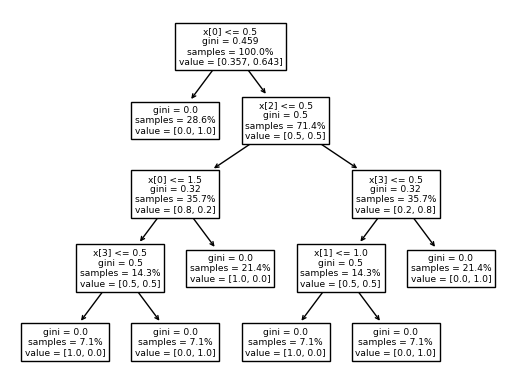

In [30]:
clf = tree.DecisionTreeClassifier().fit(X_enc, y)

tree.plot_tree(clf,proportion=True)